# Coursework 2: Image segmentation

In this coursework you will develop and train a convolutional neural network for brain tumour image segmentation. Please read both the text and the code in this notebook to get an idea what you are expected to implement. Pay attention to the missing code blocks that look like this:

```
### Insert your code ###
...
### End of your code ###
```

## What to do?

* Complete and run the code using `jupyter-lab` or `jupyter-notebook` to get the results.

* Export (File | Save and Export Notebook As...) the notebook as a PDF file, which contains your code, results and answers, and upload the PDF file onto [Scientia](https://scientia.doc.ic.ac.uk).

* Instead of clicking the Export button, you can also run the following command instead: `jupyter nbconvert coursework.ipynb --to pdf`

* If Jupyter complains about some problems in exporting, it is likely that pandoc (https://pandoc.org/installing.html) or latex is not installed, or their paths have not been included. You can install the relevant libraries and retry.

* If Jupyter-lab does not work for you at the end, you can use Google Colab to write the code and export the PDF file.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The coursework is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor. At the end, please still export everything and submit as a PDF file on Scientia.


In [1]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import tarfile
import imageio.v2 as imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
from os.path import join
import random
import matplotlib.pyplot as plt
from matplotlib import colors


## 1. Download and visualise the imaging dataset.

The dataset is curated from the brain imaging dataset in [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from T1-Gd contrast enhanced 3D brain volumes and downsample the images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [2]:

if (not os.path.isdir("Task01_BrainTumour_2D")):
    # Download the dataset
    !wget https: // www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

    # Unzip the '.tar.gz' file to the current directory
    datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
    datafile.extractall()
    datafile.close()

test_images_dir = "Task01_BrainTumour_2D/test_images"
test_labels_dir = "Task01_BrainTumour_2D/test_labels"
training_images_dir = "Task01_BrainTumour_2D/training_images"
training_labels_dir = "Task01_BrainTumour_2D/training_labels"


## Visualise a random set of 4 training images along with their label maps. [10]

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

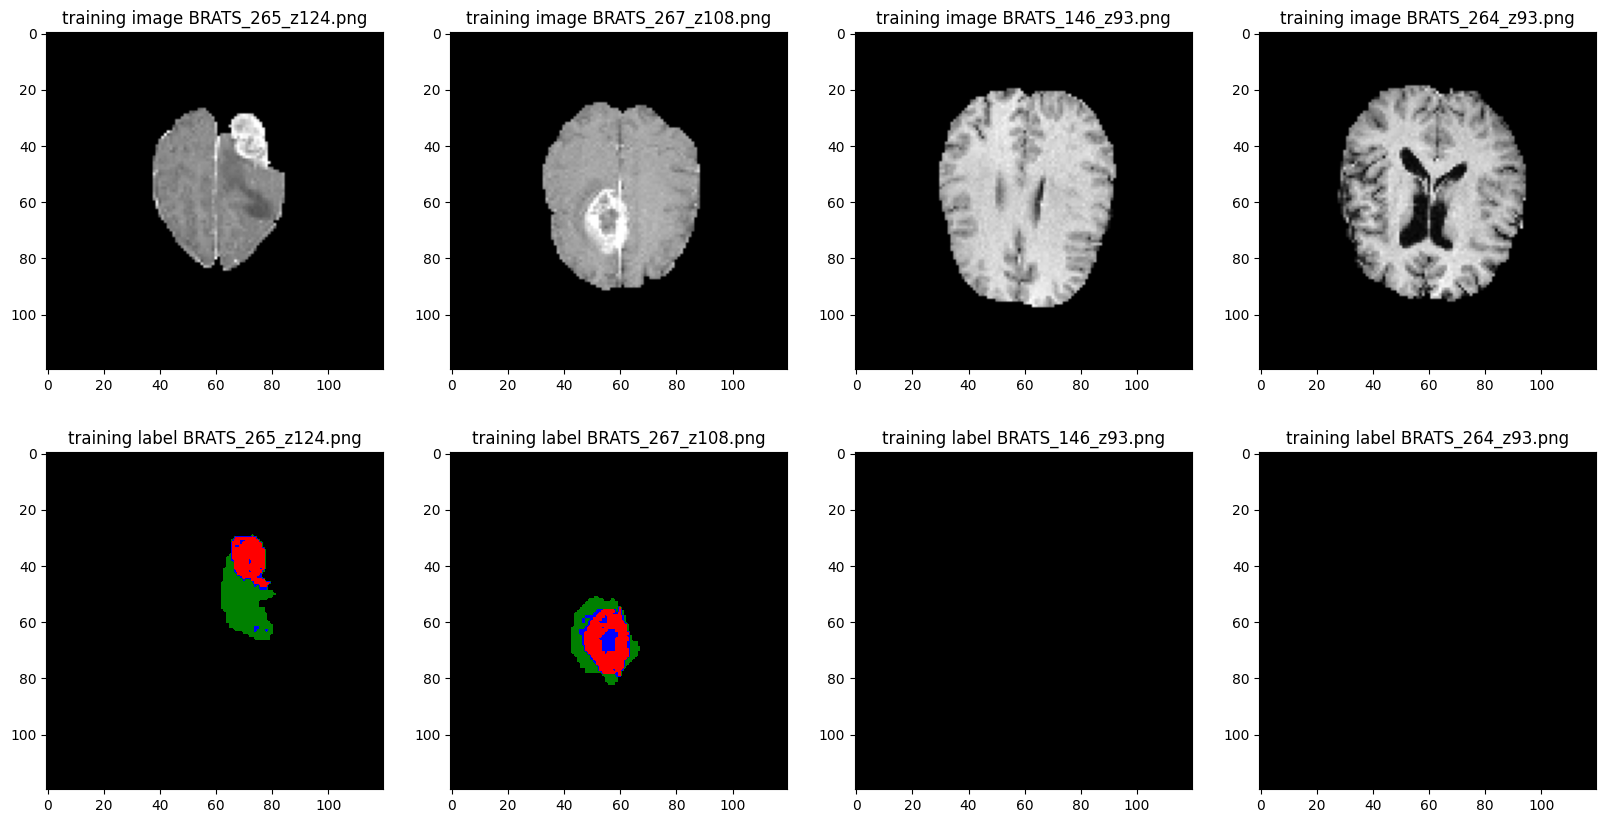

In [3]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# Select random set of 4 training images along with their label maps.
for i in range(4):
    random_training_image = random.choice(os.listdir(training_images_dir))
    random_training_image_path = join(
        training_images_dir, random_training_image)
    associated_training_label_path = join(
        training_labels_dir, random_training_image)

    img = plt.imread(random_training_image_path)
    axs[0, i].imshow(img, cmap='gray')
    axs[0, i].set_title("training image " + random_training_image)

    img = plt.imread(associated_training_label_path)
    axs[1, i].imshow(img, cmap=colors.ListedColormap(
        ['black', 'green', 'blue', 'red']))
    axs[1, i].set_title("training label " + random_training_image)


## 2. Implement a dataset class. [10]

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [4]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """

    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY

        index_of_random_images = random.sample(
            range(0, self.__len__()), batch_size)
        image_pairs = [self.__getitem__(x) for x in index_of_random_images]

        images, labels = map(list, zip(*image_pairs))
        images = np.stack([np.expand_dims(i, axis=0) for i in images])
        labels = np.array(labels)

        return images, labels


## 3. Build a U-net architecture. [20]

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters. We have implemented the encoder path. Please complete the decoder path.

![image.png](u-net-architecture.png)

This is the over-arching architecture for U-net. Therefore, it consists of the following steps:

1. $\verb!Contracting!$ step. Where, for each step we:
 * perform two $3 \times 3$ convolutions (unpadded convolutions)
 * each followed by ReLU layer
 * and a $2 \times 2$ max pooling operation with stride $2$ for downsampling
2. $\verb!Downsampling!$ step. Where, for each step we:
 * upsample the feature map followed by a 2x2 convolution (“up-convolution”) that halves the
number of feature channels
 * a concatenation with the correspondingly cropped feature map from the contracting path
 * two 3x3 convolutions
 * each followed by a ReLU
 
The cropping for the $\verb!downsampling!$ step is necessary due to the loss of border pixels in every convolution. At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. In total the network has 23 convolutional layers.

In [26]:
def define_unet_layer(input_channels: int, output_channels: int, padding=1):
    r"""
        Models the creation of multiple layers which are then grouped into a single
        module that can be called as a single unit.

        Consists of the following steps, useful in the contracting path of the 
        U-Net architecture of a typical convolution network:
        - repeated application of two 3x3 convolutions (unpadded convolutions)
        - each followed by a rectified linear unit (ReLU)
    """
    return nn.Sequential(
        nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=padding),
        nn.BatchNorm2d(output_channels),
        nn.ReLU(),
        nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=padding),
        nn.BatchNorm2d(output_channels),
        nn.ReLU()
    )


def define_contracting_module(input_channels: int, output_channels: int):
    r"""
    We expect that at each downsampling step we double the number of feature channels.
    - application of two 3x3 convolution (unpadded convolution)
    - each followed by a rectified linear unit (ReLU)
    - 2x2 max pooling operation with stride 2 for downsampling
    """
    downsampler = define_unet_layer(input_channels, output_channels)
    max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
    return downsampler, max_pool


def define_expansive_module(input_channels: int, output_channels: int):
    r"""
    We expect that each 2x2 convolution halves the number of feature channels.
    Also, prior to calling the modules, we have concatenated the correspondingly cropped feature map from the contracting path.
    - upsample of the feature map
    - a 2x2 convolution (“up-convolution”)
    - two 3x3 convolutions
    - each followed by a ReLU.
    """
    upsampler = define_unet_layer(input_channels, output_channels)
    up_conv = nn.ConvTranspose2d(input_channels, output_channels, kernel_size=2, stride=2)
    return up_conv, upsampler


def apply_encoder_step(conv_down, max_pool, source):
    # print("------") # debug

    result_of_convolution = conv_down(source)

    # print(f"conv_down: {result_of_convolution.shape}") # debug

    result_of_max_pool = max_pool(result_of_convolution)

    # print(f"max_pool: {result_of_max_pool.shape}") # debug

    return result_of_convolution, result_of_max_pool

def apply_decoder_step(up_conv_2x2, conv_up, corresponding_feature_map, source):
    # print("------") # debug

    result_of_up_convolution = up_conv_2x2(source)

    # print(f"up_conv_2x2: {result_of_up_convolution.shape}") # debug

    # We need to apply cropping to the corresponding_feature_map due to the loss of border pixels in every convolution.
    # Assueme that the input is a square image, therefore the crop along the height and width are identical, thus we only
    # need to calculate this for one dimension, and crop for both.

    diff = (corresponding_feature_map.shape[2] - result_of_up_convolution.shape[2]) // 2
    result_of_cropping = corresponding_feature_map if diff == 0 else corresponding_feature_map[:, :, diff:-diff, diff:-diff]
    
    # print(f"result_of_cropping: {result_of_cropping.shape}") # debug

    result_of_concatenation = torch.cat((result_of_cropping, result_of_up_convolution), dim=1)

    # print(f"result_of_concatenation: {result_of_concatenation.shape}") # debug

    result_of_convolution = conv_up(result_of_concatenation)

    # print(f"conv_up: {result_of_convolution.shape}") # debug

    return result_of_convolution

""" U-net """


class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()
        
        # Encoder path

        n = num_filter  # 1 -> 16
        self.conv_down_1, self.max_pool_1 = define_contracting_module(input_channel, n)

        n *= 2  # 16 -> 32
        self.conv_down_2, self.max_pool_2 = define_contracting_module(n // 2, n)

        n *= 2  # 32 -> 64
        self.conv_down_3, self.max_pool_3 = define_contracting_module(n // 2, n)

        n *= 2  # 64 -> 128
        self.conv_down_4, self.max_pool_4 = define_contracting_module(n // 2, n)

        # Bottom Layer

        n *= 2  # 128 -> 256
        self.bottom_layer = define_unet_layer(n // 2, n)

        # Decoder path

        n = n // 2  # 256 -> 128
        self.up_conv_2x2_5, self.conv_up_5 = define_expansive_module(n * 2, n)

        n = n // 2  # 128 -> 64
        self.up_conv_2x2_6, self.conv_up_6 = define_expansive_module(n * 2, n)

        n = n // 2  # 64 -> 32
        self.up_conv_2x2_7, self.conv_up_7 = define_expansive_module(n * 2, n)

        n = n // 2  # 32 -> 16
        self.up_conv_2x2_8, self.conv_up_8 = define_expansive_module(n * 2, n)

        # At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes.
        self.conv9 = nn.Conv2d(n, output_channel, kernel_size=1)

    def forward(self, x):
        # I have decided to pad the original image becuase the resulting size of my image
        # is way too small to pass through the bottom layer. To pad the last 2 dimensions of the input tensor:
        # $(padding_left, padding_right, padding_top, padding_bottom)$
        initial_padding = 20
        x = F.pad(x, (initial_padding, initial_padding, initial_padding, initial_padding), mode='constant', value=0)
        
        # print("X: " + str(x.shape))
        
        # Encoder
        conv1_skip, x = apply_encoder_step(self.conv_down_1, self.max_pool_1, x)
        conv2_skip, x = apply_encoder_step(self.conv_down_2, self.max_pool_2, x)
        conv3_skip, x = apply_encoder_step(self.conv_down_3, self.max_pool_3, x)
        conv4_skip, x = apply_encoder_step(self.conv_down_4, self.max_pool_4, x)

        # Bottom
        x = self.bottom_layer(x)
        # print("------\nbottom.shape: " + str(x.shape)) # debug

        # Decoder
        x = apply_decoder_step(self.up_conv_2x2_5, self.conv_up_5, conv4_skip, x)
        x = apply_decoder_step(self.up_conv_2x2_6, self.conv_up_6, conv3_skip, x)
        x = apply_decoder_step(self.up_conv_2x2_7, self.conv_up_7, conv2_skip, x)
        x = apply_decoder_step(self.up_conv_2x2_8, self.conv_up_8, conv1_skip, x)

        # Final 1x1 convolution
        x = self.conv9(x)
        
        # Crop back to the original size
        if ( initial_padding != 0):
            x = x[:, :, initial_padding:-initial_padding, initial_padding:-initial_padding]
        # print("------\nx.shape: " + str(x.shape)) # debug

        return x


## 4. Train the segmentation model. [20]

In [49]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet(training_images_dir, training_labels_dir)
test_set = BrainImageSet(test_images_dir, test_labels_dir)

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(
        device, dtype=torch.long)
    logits = model(images)  # forward pass

    # for each entity of data, we zero out the gradients.
    # This is to ensure that we aren’t tracking any unnecessary information when we train our neural network.
    optimizer.zero_grad()

    # Perform optimisation and print out the training loss
    # 1. Perform optimisation:
    # calculate the loss with respect to the output and the expected labels
    loss = criterion(logits, labels)

    # backward pass and update weights
    loss.backward()
    optimizer.step()

    # 2. Print training loss
    print(f"Training Loss ({it}): {loss.item()}")

    # 2. Print the training loss

    # Evaluate
    if it % 100 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            test_images, test_labels = test_set.get_random_batch(
                eval_batch_size)
            test_images, test_labels = torch.from_numpy(
                test_images), torch.from_numpy(test_labels)
            test_images, test_labels = test_images.to(
                device, dtype=torch.float32), test_labels.to(device, dtype=torch.long)
            logits = model(test_images)
            loss = criterion(logits, test_labels)
            print(f"==========================\n Test loss: {loss.item()}\n==========================")

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(
            model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))


Device: cpu
Training Loss (1): 1.6575604677200317
Training Loss (2): 1.492287039756775
Training Loss (3): 1.3688603639602661
Training Loss (4): 1.2848293781280518
Training Loss (5): 1.2214080095291138
Training Loss (6): 1.1771316528320312
Training Loss (7): 1.1299296617507935
Training Loss (8): 1.1000910997390747
Training Loss (9): 1.0790272951126099
Training Loss (10): 1.0628644227981567
Training Loss (11): 1.0338163375854492
Training Loss (12): 1.015955924987793
Training Loss (13): 0.9983595013618469
Training Loss (14): 0.9841970205307007
Training Loss (15): 0.9699215888977051
Training Loss (16): 0.9607603549957275
Training Loss (17): 0.9441526532173157
Training Loss (18): 0.9287242889404297
Training Loss (19): 0.9189063310623169
Training Loss (20): 0.9117429852485657
Training Loss (21): 0.9015690088272095
Training Loss (22): 0.8876891136169434


## 5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation. [20]

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation. 

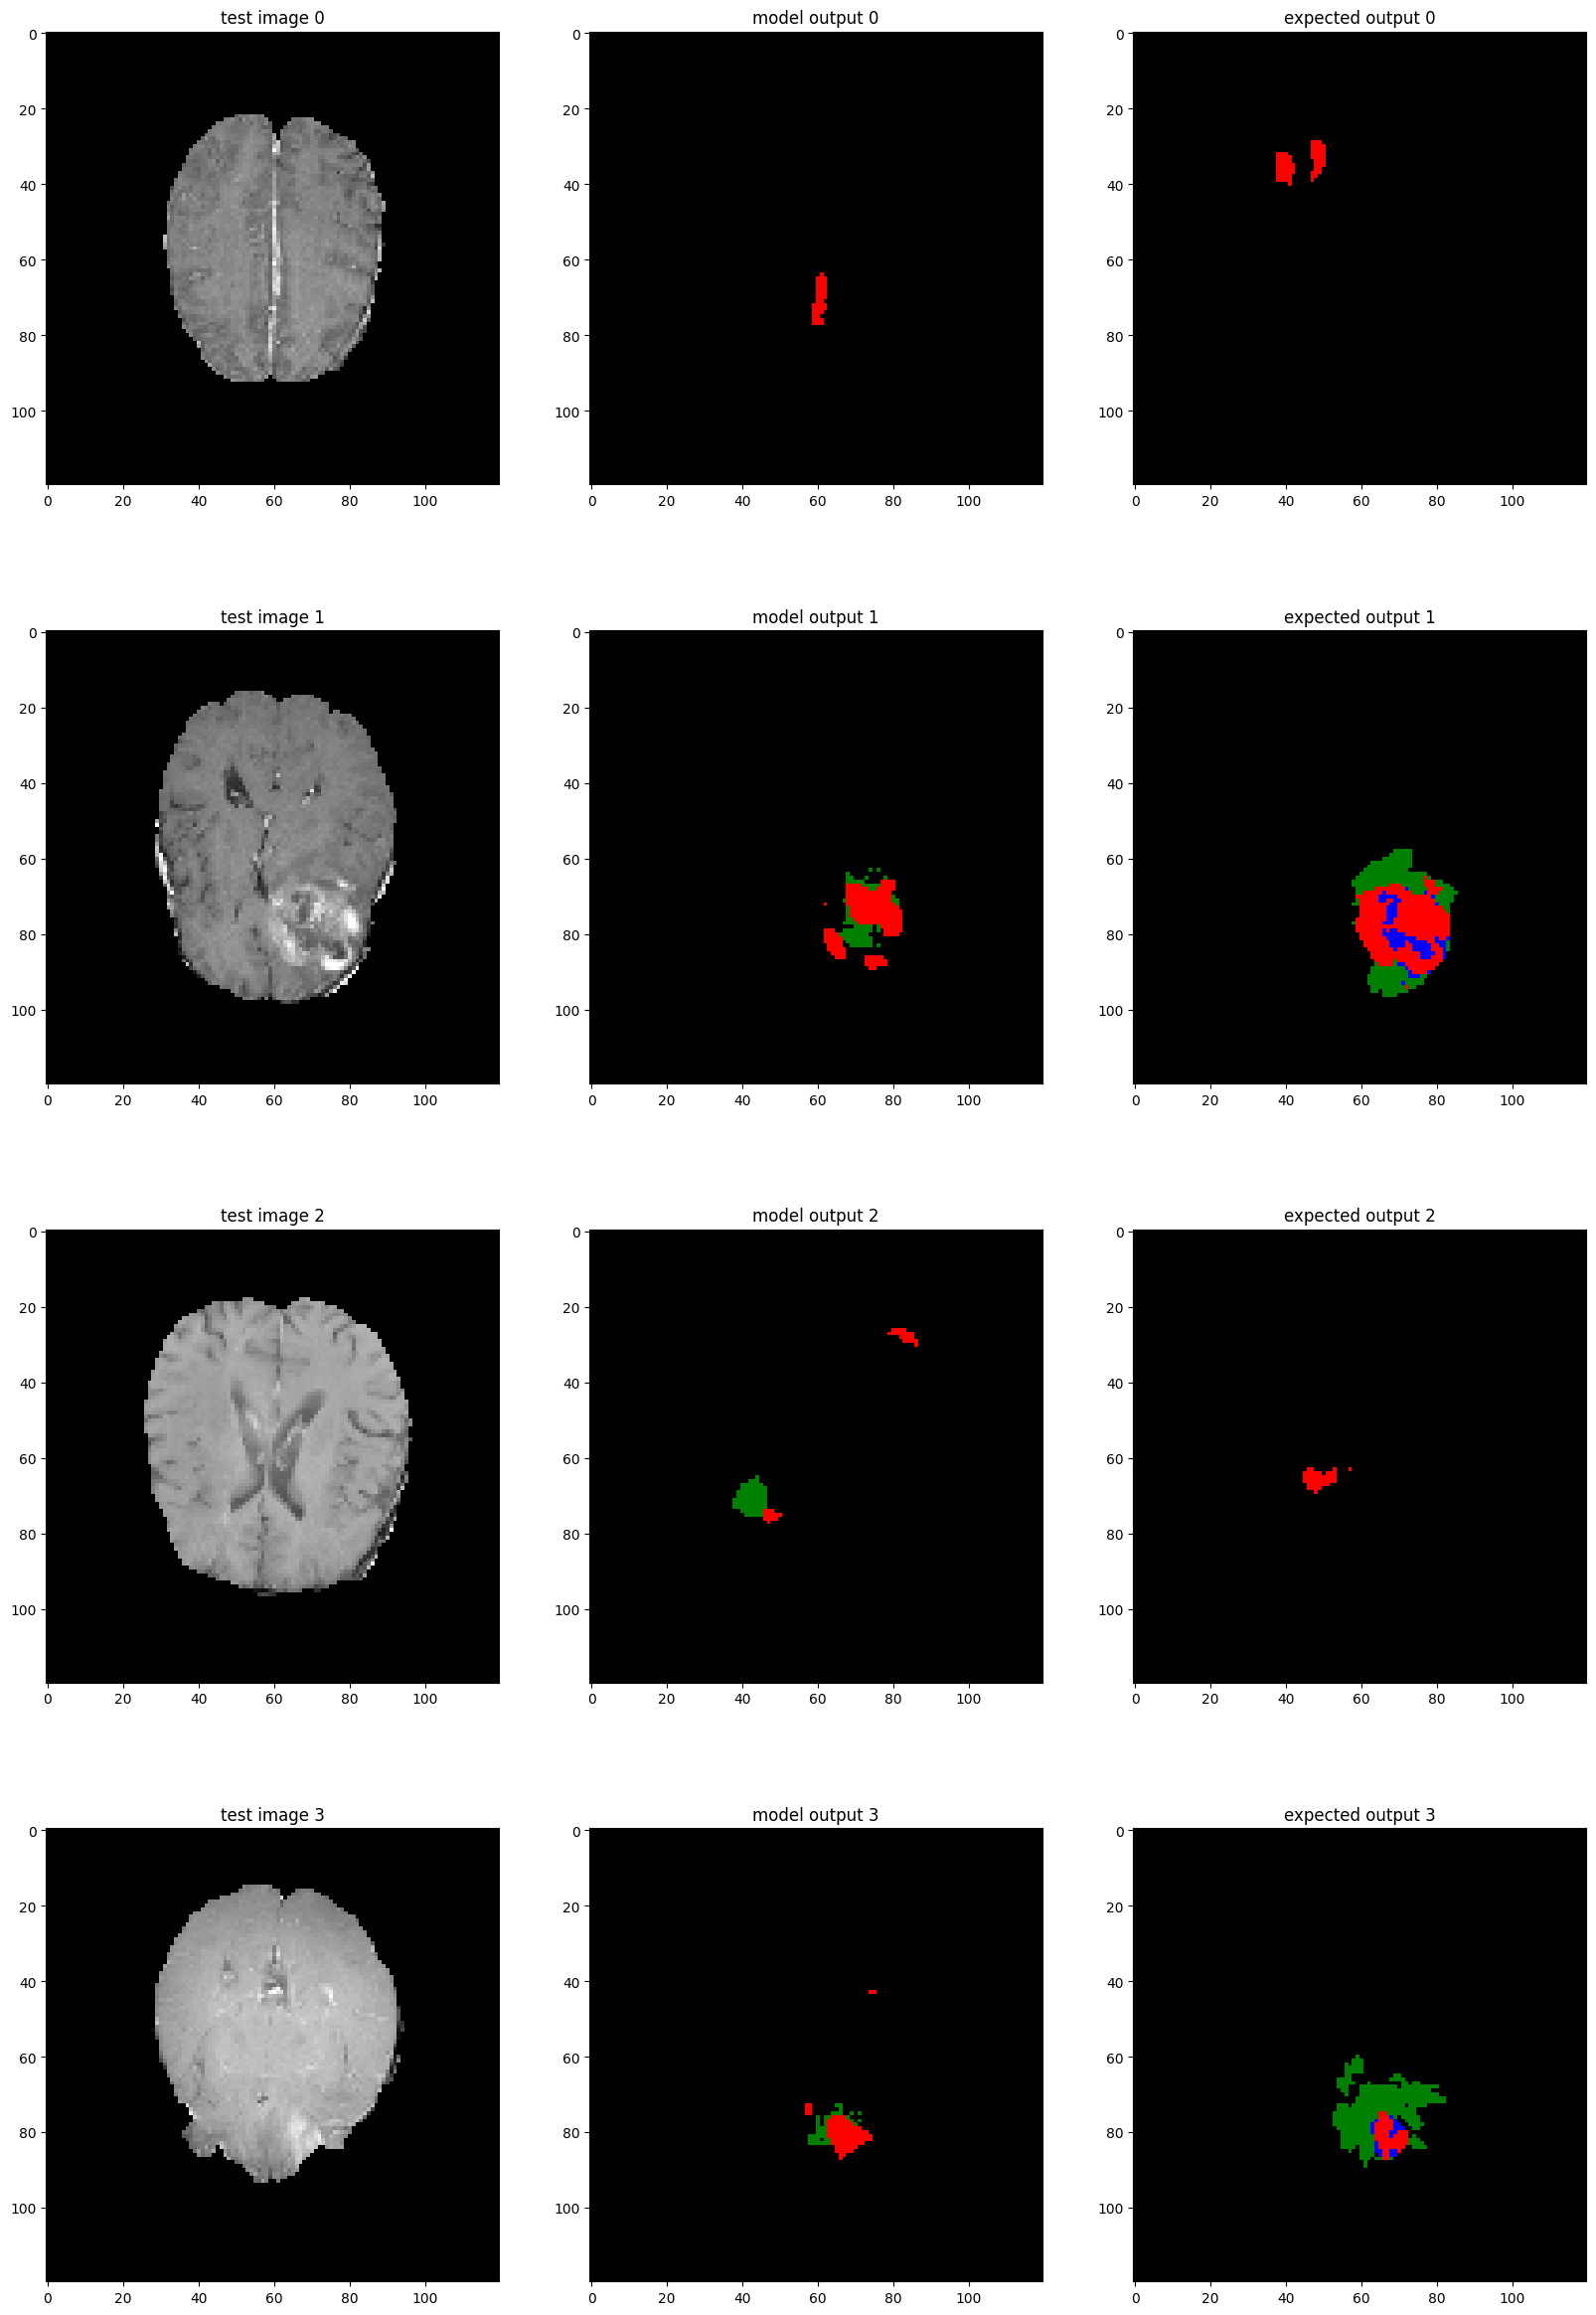

In [48]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 30))

# Select random set of 4 training images along with their label maps
images, labels = test_set.get_random_batch(4)
# Translate, similarly to how we did in training
images, labels = torch.from_numpy(images), torch.from_numpy(labels)
images, labels = images.to(device, dtype=torch.float32), labels.to(
    device, dtype=torch.long)

for i in range(4):
    img = images[i]
    axs[i, 0].imshow(img.numpy().squeeze(), cmap='gray')
    axs[i, 0].set_title("test image " + str(i))

    with torch.no_grad():
        img = model(img[None, :, :, :])
        argmax = img.squeeze(dim=0)
        argmax = torch.argmax(argmax, dim=0)
        argmax = torch.squeeze(argmax)
        axs[i, 1].imshow(argmax.numpy(), cmap=colors.ListedColormap(
            ['black', 'green', 'blue', 'red']))
        axs[i, 1].set_title("model output " + str(i))

    img = labels[i]
    axs[i, 2].imshow(img, cmap=colors.ListedColormap(
        ['black', 'green', 'blue', 'red']))
    axs[i, 2].set_title("expected output " + str(i))


## 6. Discussion. Does your trained model work well? How would you improve this model so it can be deployed to the real clinic? [20]